# Thermal-Hydraulics of a pin
This notebook implements the thermal-hydraulic analysis of a pin inside a nuclear reactor. The main output will be the temperature at different heights for all the materials (cladding, helium and fuel), returned from the following equations
\begin{equation}
\left\{
\begin{array}{ll}
    -\nabla\cdot (k\nabla T)=q'''(\mathbf{x}) & \mathbf{x}\in\Omega\\ & \\
    -k\frac{\partial T}{\partial \mathbf{n}} = h(T-T_b) & \mathbf{x}\in\Gamma_w\\ & \\
    -k\frac{\partial T}{\partial \mathbf{n}}=0 & \mathbf{x}\in\partial \Omega\setminus\Gamma_w
\end{array}
\right.
\end{equation}

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{amsthm} \usepackage{mathtools}'

import numpy as np
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator, interp2d, interp1d
import tqdm

import dolfinx
from dolfinx import fem
from dolfinx.fem import (Constant, Function, FunctionSpace, assemble_scalar, 
                        dirichletbc, form, locate_dofs_topological, locate_dofs_geometrical)
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import XDMFFile, gmshio
from dolfinx import mesh

import ufl
from ufl import (FacetNormal, FiniteElement, TestFunction, TrialFunction, VectorElement,
                 div, dot, grad, ds, dx, lhs, rhs, inner, nabla_grad)

from mpi4py import MPI
from petsc4py import PETSc

Some important tools must be defined: the inner product in $L^2$ and $H^1$
\begin{equation}
\left\langle u,\, v\right\rangle_{L^2} = \int_\Omega u\,v\,d\Omega\qquad \qquad
\left\langle u,\, v\right\rangle_{H^1} = \int_\Omega \nabla u\cdot\nabla v\,d\Omega
\end{equation}
from which the correspondent norms are derived
\begin{equation}
\|u\|_{L^2} = \sqrt{\left\langle u,\, u\right\rangle_{L^2}}\qquad \qquad 
\|u\|_{H^1} = \sqrt{\left\langle u,\, u\right\rangle_{H^1}}
\end{equation}
In addition, the $L^\infty$ norm is defined
\begin{equation}
\|u\|_{L^\infty} = \max\limits_{x\in\Omega} |u(x)|
\end{equation}

The Functional Space into which the solution of the PDEs is composed by linear Finite Element (P1), in order to have a better computation of the integrals, the norms and the scalar product are computed considering parabolic Finite Element (P2).

In [2]:
class norms():
  def __init__(self, funSpace, domain):
    self.domain = domain
    self.trial = ufl.TrialFunction(funSpace)
    self.test  = ufl.TestFunction(funSpace)

    self.L2inner = inner(self.trial, self.test) * dx
    self.H1inner = inner(grad(self.trial), grad(self.test)) * dx

  def L2norm(self, u):
    repl_form = form(ufl.replace(self.L2inner, {self.trial: u, self.test: u}))
    return np.sqrt( self.domain.comm.allreduce(assemble_scalar(repl_form), op=MPI.SUM) )
    
  def H1norm(self, u):
    repl_form = form(ufl.replace(self.H1inner, {self.trial: u, self.test: u}))
    return np.sqrt( self.domain.comm.allreduce(assemble_scalar(repl_form), op=MPI.SUM) )
    
  def L2innerProd(self, u, v):
    repl_form = form(ufl.replace(self.L2inner, {self.trial: u, self.test: v}))
    return self.domain.comm.allreduce(assemble_scalar(repl_form), op=MPI.SUM)

  def Linftynorm(self, u):
    return self.domain.comm.allreduce(np.max(np.abs(u.x.array)), op = MPI.MAX)

At first, the geometry and the mesh are imported from "pin2D.msh".

In [3]:
gdim = 2

from dolfinx.io import XDMFFile, gmshio

domain, ct, ft = gmshio.read_from_msh("pin2D_solid.msh", MPI.COMM_WORLD, gdim = gdim)

fuel_marker   = 1
helium_marker = 2
clad_marker   = 3
graph_marker  = 5

water_out_marker = 10
out_marker = 20
centre_marker = 30
in_marker = 40

Info    : Reading 'pin2D_solid.msh'...
Info    : 45 entities
Info    : 21968 nodes
Info    : 22776 elements
Info    : Done reading 'pin2D_solid.msh'


### Definition of the functional space and boundary conditions
The following lines are used to import all the necessary libraries, define the functional space and the boundary conditions.

In [4]:
tdim = domain.topology.dim

fdim = tdim - 1

domain.topology.create_connectivity(fdim, tdim)

## Functional Spaces
scalarElement = ufl.FiniteElement("CG", domain.ufl_cell(), 1)
V = FunctionSpace(domain, scalarElement)

### Define parameter functions on the different regions
Since there are 4 subdomains in $\Omega$ (i.e., fuel, helium, cladding and water) the values of the parameters changes according to the region, therefore proper functions should be defined in a Discountinuous Galerkin Finite Element space.

In [5]:
class parameterFun():
    def __init__(self, cell_tag, funSpace: FunctionSpace):
        self.regionMarker = []
        self.cell_tag = cell_tag
        self.funSpace = funSpace

    def appendRegion(self, new_marker):
        self.regionMarker.append(new_marker)
        
    def assign(self, value_vec):
        fun = Function(self.funSpace)
        
        for idx in range(len(self.regionMarker)):
            regionI = self.regionMarker[idx]
            region_cells = self.cell_tag.find(regionI)
            fun.x.array[region_cells] = np.full_like(region_cells, value_vec[idx], dtype=PETSc.ScalarType)
        
        return fun
    
    
V_parameters = FunctionSpace(domain, ("DG", 0))
parameters = parameterFun(ct, V_parameters)

parameters.appendRegion(fuel_marker)
parameters.appendRegion(helium_marker)
parameters.appendRegion(clad_marker)
parameters.appendRegion(graph_marker)

k_value   = np.array([16, 0.15, 235, 140]) / 100. # W/cm-K # water value at p = 1 bar, T = 40 C

is_fuel   = np.array([1., 0., 0., 0.]) 
is_helium = np.array([0., 1., 0., 0.]) 
is_clad   = np.array([0., 0., 1., 0.]) 
is_grap   = np.array([0., 0., 0., 1.])

### Variational formulation
Given the problem in strong form, we can define the variational formulation starting from the following functional spaces
\begin{equation}
\mathcal{V}=\mathcal{V}_0=\mathcal{H}^1(\Omega)
\end{equation}
Using the integration by parts the weak formulation reads:
\begin{equation}
\begin{split}
\int_\Omega k\nabla T\cdot\nabla v\,d\Omega - \int_{\partial\Omega}k\frac{\partial T}{\partial \mathbf{n}}\, v\,d\sigma&=  \int_\Omega q''' \, v\,d\Omega\\
\int_\Omega k\nabla T\cdot\nabla v\,d\Omega + \int_{\Gamma_w}h(T-T_b)\, v\,d\sigma&=  \int_\Omega q''' \, v\,d\Omega\\
\int_\Omega k\nabla T\cdot\nabla v\,d\Omega + \int_{\Gamma_w}h \,T\, v\,d\sigma&=  \int_\Omega q''' \, v\,d\Omega+\int_{\Gamma_w}h\,T_b\, v\,d\sigma
\end{split}
\end{equation}

In [6]:
class thermal():
    def __init__(self, domain, ft, funSpace, parameterClass, k_value, is_fuel):

        self.domain = domain
        self.ft = ft
        self.funSpace = funSpace

        self.gdim = self.domain.geometry.dim
        self.fdim = self.gdim - 1

        self.k        = parameterClass.assign(k_value)
        self.is_fuel  = parameterClass.assign(is_fuel)

        self.T = ufl.TrialFunction(self.funSpace)
        self.v = ufl.TestFunction(self.funSpace)

        self.ds = ufl.Measure('ds', domain=self.domain, subdomain_data=self.ft)
        
    def assemble(self, h, robin_mark):

        self.robin_mark = robin_mark
        self.h = fem.Constant(self.domain, PETSc.ScalarType(h))

        self.T_b = Function(self.funSpace)
        self.q  = Function(self.funSpace)
        
        self.left_side  = (inner(self.k * grad(self.T), grad(self.v))  * dx + 
                           inner(self.h * self.T, self.v) * self.ds(self.robin_mark) )
        
        self.right_side = (inner(self.is_fuel * self.q, self.v) * dx +
                          inner(self.h * self.T_b, self.v) * self.ds(self.robin_mark) )
        
        self.a = form(self.left_side)
        self.L = form(self.right_side)
        
        self.A = fem.petsc.assemble_matrix(self.a)
        self.A.assemble()
        self.b = fem.petsc.create_vector(self.L)
        
        self.solver = PETSc.KSP().create(self.domain.comm)
        self.solver.setOperators(self.A)
        self.solver.setType(PETSc.KSP.Type.CG)
        self.pc = self.solver.getPC()
        self.pc.setType(PETSc.PC.Type.SOR)
        
    def solve(self, power_fun, T_b_fun): # power function should be a callable interpolant
        
        self.q.interpolate(lambda x: power_fun(x[0], x[1]))
        self.T_b.interpolate(lambda x: T_b_fun(x[0], x[1]))
        
        with self.b.localForm() as loc:
            loc.set(0)
        fem.petsc.assemble_vector(self.b, self.L)
        self.b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        
        solution = Function(self.funSpace)
        self.solver.solve(self.b, solution.vector)
        solution.x.scatter_forward()
        
        return solution

    def plot2D(self, T, L, R, filename):
        
        Nx, Ny = 140, 100
        x_grid = np.linspace(-L/2, L/2, Nx)
        y_grid = np.linspace(0, R, Ny)

        T_matrix = np.zeros((Nx, Ny))

        for ii in range(Nx):
            points = np.zeros((3, Ny))
            points[0, :] = x_grid[ii]
            points[1, :] = y_grid

            bb_tree = dolfinx.geometry.BoundingBoxTree(self.domain, self.domain.topology.dim)
            cells = []
            points_on_proc = []
            cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
            colliding_cells = dolfinx.geometry.compute_colliding_cells(self.domain, cell_candidates, points.T)
            for i, point in enumerate(points.T):
                if len(colliding_cells.links(i))>0:
                    points_on_proc.append(point)
                    cells.append(colliding_cells.links(i)[0])
            xPlot = np.array(points_on_proc, dtype=np.float64)

            T_matrix[ii, :] = T.eval(xPlot, cells).flatten()
        
        X, Y = np.meshgrid(x_grid, y_grid)
        fig = plt.figure( figsize = (14,3) )
        plt.contourf(X, Y, T_matrix.T, cmap=cm.jet, levels = 40)
        plt.colorbar()
        plt.xlabel(r'$z$', fontsize = 20)
        plt.ylabel(r'$r$', fontsize = 20)
        plt.title(r'Temperature $T\,[K]$', fontsize = 20)
                         
        fig.savefig(filename+'.pdf', format='pdf', dpi=600, bbox_inches='tight')
        
    def plot1D_y(self, T, L, R, filename):
        
        Ny = 100
        x_grid = np.array([-L/4, -L/8, 0., L/8, L/4])
        Nx = len(x_grid)
        y_grid = np.linspace(0, R, Ny)

        fig = plt.figure (figsize = (6,4))
        for ii in range(Nx):
            points = np.zeros((3, Ny))
            points[0, :] = x_grid[ii]
            points[1, :] = y_grid

            bb_tree = dolfinx.geometry.BoundingBoxTree(self.domain, self.domain.topology.dim)
            cells = []
            points_on_proc = []
            cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
            colliding_cells = dolfinx.geometry.compute_colliding_cells(self.domain, cell_candidates, points.T)
            for i, point in enumerate(points.T):
                if len(colliding_cells.links(i))>0:
                    points_on_proc.append(point)
                    cells.append(colliding_cells.links(i)[0])
            xPlot = np.array(points_on_proc, dtype=np.float64)
            
            plt.plot(xPlot[:,1], T.eval(xPlot, cells).flatten(), label = r'$z = {:.2f}'.format(x_grid[ii])+'$')

            plt.xlabel(r'$r$', fontsize = 20)
            plt.ylabel(r'$T$', fontsize = 20)
            plt.grid(which='major',linestyle='-')
            plt.grid(which='minor',linestyle='--')
            plt.legend(fontsize = 15)

        fig.savefig(filename+'.pdf', format='pdf', dpi=600, bbox_inches='tight')
        
    def plot1D_x(self, T, L, fuel_or, clad_ir, clad_or, filename):
        
        
        Nx = 100
        x_grid = np.linspace(-L/2, L/2, Nx)
        y_grid = np.array([0., fuel_or, clad_ir, clad_or])
        Ny = len(y_grid)

        fig = plt.figure (figsize = (6,4))
        for ii in range(Ny):
            points = np.zeros((3, Nx))
            points[0, :] = x_grid
            points[1, :] = y_grid[ii]

            bb_tree = dolfinx.geometry.BoundingBoxTree(self.domain, self.domain.topology.dim)
            cells = []
            points_on_proc = []
            cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
            colliding_cells = dolfinx.geometry.compute_colliding_cells(self.domain, cell_candidates, points.T)
            for i, point in enumerate(points.T):
                if len(colliding_cells.links(i))>0:
                    points_on_proc.append(point)
                    cells.append(colliding_cells.links(i)[0])
            xPlot = np.array(points_on_proc, dtype=np.float64)
            
            plt.plot(xPlot[:,0], T.eval(xPlot, cells).flatten(), label = r'$r = {:.3f}'.format(y_grid[ii])+'$')
        
            plt.xlabel(r'$z$', fontsize = 20)
            plt.ylabel(r'$T$', fontsize = 20)
            plt.grid(which='major',linestyle='-')
            plt.grid(which='minor',linestyle='--')
            plt.legend(fontsize = 15)

        fig.savefig(filename+'.pdf', format='pdf', dpi=600, bbox_inches='tight')

Let us solve the problem for some power distribution.

In [16]:
TH = thermal(domain, ft, V, parameters, k_value, is_fuel)

h = 600e-4 # W/cm2/K
TH.assemble(h, water_out_marker)

Text(0, 0.5, '$T_b(z)$')

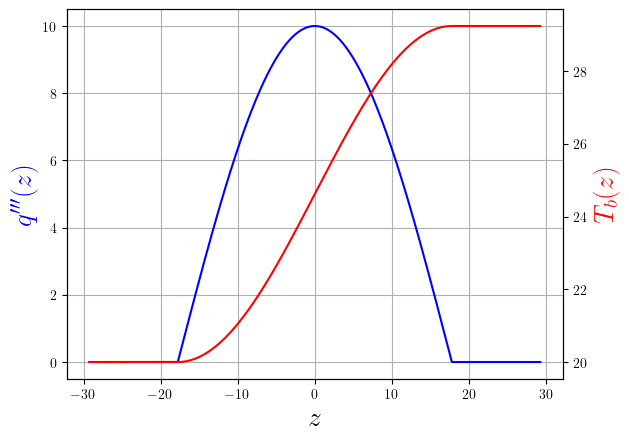

In [17]:
L = 29.25 * 2
L_active = 35.56

fuel_or = 1.791
clad_ir = 1.800
clad_or = 1.880

power_fun = lambda x, y: 10 * np.cos(np.pi*(x/L_active)) * np.piecewise(x, [ x < -L_active / 2, ((x>=-L_active/2) & (x <= L_active / 2)), x > L_active/2], 
                                                                           [0, 1, 0]) + 0.0 * y
m_cp = 0.065e3 * 4.186 # g/s * J/g/K
fig,ax = plt.subplots()
# make a plot
z = np.linspace(-L/2, L/2, 1000)
ax.plot(z, power_fun(z, 0), 'b')
ax.grid(which='major',linestyle='-')
ax.grid(which='minor',linestyle='--')
ax.set_ylabel("$q'''(z)$",color="blue", fontsize=20)
ax.set_xlabel("$z$",fontsize=20)

T_b = np.zeros((len(z), ))
T_b[0] = 20+273.16
for ii in range(1, len(z)):
    T_b[ii] = T_b[0] + 1. / m_cp * np.pi * clad_or**2 * np.trapz(power_fun(z[:ii+1], 0.), z[:ii+1])

from scipy.interpolate import interp1d
T_b_fun = interp1d(z, T_b, kind='linear',fill_value='extrapolate')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(z, T_b_fun(z)-273.16, 'r', label="$T$")
ax2.set_ylabel("$T_b(z)$",color="red", fontsize=20)


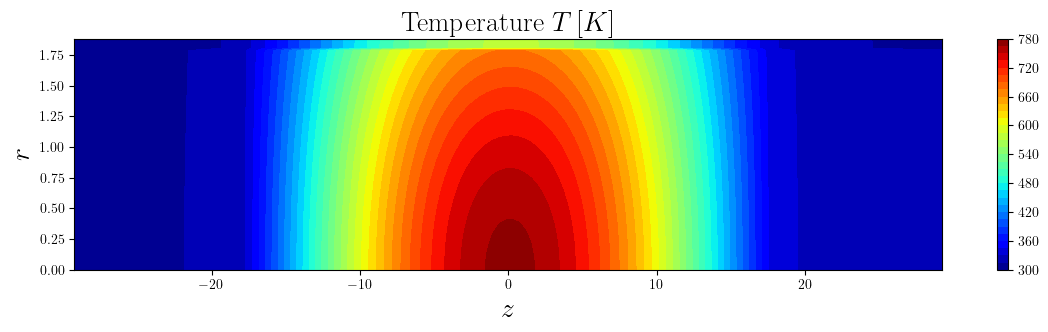

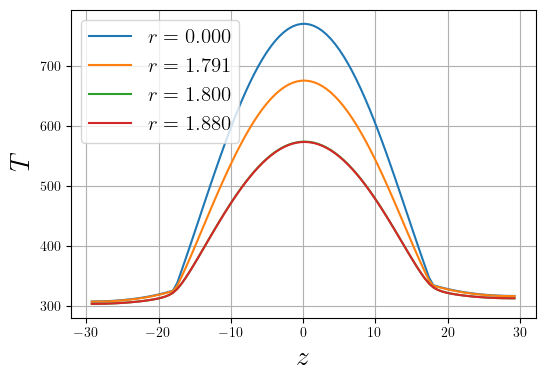

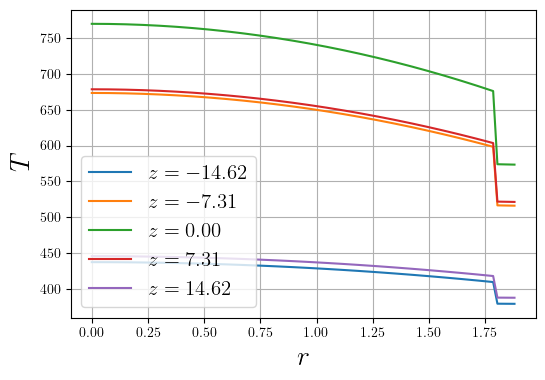

In [18]:
sol = TH.solve( power_fun, lambda x, y: T_b_fun(x) )

TH.plot2D(sol, L, clad_or, 'T_snap')
# TH.power_fun = Function(TH.funSpace)
# TH.power_fun.interpolate( fem.Expression( TH.is_fuel * TH.q, TH.funSpace.element.interpolation_points() ))
# TH.plot2D(TH.power_fun, L, clad_or, 'power')
# TH.plot2D(TH.k, L, clad_or, 'th_cond')
TH.plot1D_x(sol, L, fuel_or, clad_ir, clad_or, 'AxialPlot')
TH.plot1D_y(sol, L, clad_or, 'RadialPlots')